# Report 2
## Median Household By County

# Introduction

According to the Census Buraeu, a household refers to a single housing unit and all of the people that live in it. Median Householed Income is a measure by which the average amount of income garnered in a household is calculated. It is a measurement that can be used to determine the affluence of a county based upon it's households median salary. 

Median Household Income can give an accurate picture of an areas economic status. Median Household Income is also used in real estate to calculate the affordibility of housing. Affordable housing is also defined relative to median household income.[1] 

The goal of my report was to color a svg map of the United States using the Median Household Income of each county. My main focus is on how well the individual counties refelct the Median Household Income of the entire state.

## Code

Here I am importing pandas for the dataframe and initializing the df to start the project

In [55]:
import pandas as pd
#myformatter = str 
mycons = { 1:str, 2:str }
df = pd.read_excel('Unemployment.xls',header=None,skiprows=6,converters=mycons)
df.columns
df.drop(0, inplace=True)
df.drop(1, inplace=True)
df.columns=['FIPS','Abreviation','State','Civilian labor force','Employed','Unemployed','Unemployment_rate','Median Household Income', 'Med HH Income % of state total']
df.head()

,FIPS,Abreviation,State,Civilian labor force,Employed,Unemployed,Unemployment_rate,Median Household Income,Med HH Income % of state total
2,1000,AL,Alabama,2198837,2112347,86490,3.9,48193,100
3,1001,AL,"Autauga County, AL",25957,25015,942,3.6,58343,121.1
4,1003,AL,"Baldwin County, AL",93849,90456,3393,3.6,56607,117.5
5,1005,AL,"Barbour County, AL",8373,7940,433,5.2,32490,67.4
6,1007,AL,"Bibb County, AL",8661,8317,344,4,45795,95


I am displaying the df for my own idea of the layout of the df so I know how to access specific datum.

Here I create two dictionaries to hold the FIPS ids with their respective Median
Household Income

In [61]:
FIPS_income = {}
State_FIPS = {}
for data in df.itertuples():
    #the entry for FIPS is an integer in the df so it needs to be casted to a str
    #the str then needs to have 5 chars in it due to the representation of it in the svg
    #svg['id'] is the FIPS code for each county and is a 5 char str
    if len(str(data[1])) == 4:
        fips = '0' + str(data[1])
    else:
        fips = str(data[1])
    #The value of each FIPS Median Household Income is set in the dictionaries
    #I have two dictionaries, one for the county MHI and one for the state MHI, to make it
    #easier for when I am constructing the two maps for comparison
    if fips[-3:] == '000':
        State_FIPS[fips] = data[8]
    else:
        FIPS_income[fips] = data[8]

This was support code created by the professor to create the color scale for the maps
to follow

In [43]:
import requests
from IPython.display import SVG
from lxml import etree
import numpy as np

def add_scale(svg_map_in, colors, labels, font_size=6, stroke=False, save_file=None):
    '''
    :svg_map_in:
             Our US counties SVG map as an lxml.etree.
    :colors: 
             A list of colors in hex format.
    :labels: 
             A list of strings or numbers for uniformly spaced scale labels. 
    :font_size:
             The size of labels font.
    :stroke:
             Whether to stroke the individual segments of the color scale.
    :save_file:
             The name of the file where the map with the scale should be 
             saved. If None, nothing will be saved.\
    Returns:
             The modified svg_map. 
    '''

    def set_props(elt, d):
        '''
        Utility function for assigning attributes to SVG elements
        from a dictionary.
        '''
        for k, v in d.items():
            elt.set(k,v)
            
    # coordinates of the upper left corner of the scale
    scale_x = 515
    scale_y = 180
    # scale dimensions
    scale_height = 150
    scale_width = 10
    # x-coordinates of scale labels
    label_x = 528
    
    # convert labels to strings if needed
    minus_sign = '−'
    labels = [str(x).replace('-',minus_sign) for x in labels]
    
    Nc = len(colors)
    hc = scale_height/Nc
    Nl = len(labels)
    hl = (scale_height)/(Nl-1)
    
    # attributes of scale rectangles
    rect_props = {"x": f"{scale_x}", 
                  "width": f"{scale_width}",
                  "height": f"{hc}",
                  "stroke": "black", 
                  "stroke-width": "0.25"}
    
    # attributes of scale labels
    label_props = {"x": f"{label_x}", 
                   "text-anchor": "start", 
                   "dominant-baseline": "central",
                   "font-size": f"{font_size}", 
                   "font-family": "sans-serif"}
    
    # make a copy of the tree so that the input object will remain unaltered
    strmap = str(etree.tostring(svg_map_in).decode("utf8"))
    svg_map = etree.fromstring(strmap.encode("utf8")) # using string form to obviate deepcopy
    
    # create group element for the scale
    scale = etree.SubElement(svg_map, "g")
    scale.set("id", "color_scale")
    
    for i in range(Nc):
        rect_y = f"{scale_y + scale_height -(i+1)*hc}"
        rect_props["id"] = f"scale_rect_{i}"
        rect_props["y"] = rect_y
        rect_props["fill"] = colors[i]
        if not stroke:
            rect_props["stroke"] = "None"
            rect_props["shape-rendering"]="crispEdges"
        rect = etree.SubElement(scale, "rect")
        set_props(rect, rect_props)
        
    for i in range(Nl):
        label_y = f"{scale_y + scale_height - i*hl}"
        label =  etree.SubElement(scale, "text")
        label_props["id"] = f"scale_label_{i}"
        label_props["y"] = label_y
        set_props(label, label_props)
        label.text = labels[i]
    
    if save_file is not None:
        new_map = etree.tostring(svg_map).decode("utf8")
        with open(save_file, "w") as foo:
            foo.write(new_map) 
    
    return svg_map

This block of code writes functions to make the maps

In [44]:
def makemap(c0,c1,xlo,xhi):  # from class Day 7
    def themap(x):
        # c0, c1 are triples in [0,255]
        ac0 = np.array(c0) 
        ac1 = np.array(c1)
        h = (x-xlo)/(xhi-xlo) 
        #print(x,h)
        c = np.array( (1-h)*ac0 + h*ac1, dtype=int)
        return '#{:02x}{:02x}{:02x}'.format(*list(c))
    return themap

In [45]:
def midpoints(xlo,xhi,n):
    '''Return an array of the midpoints of n equal subintervals of the interval [xlo,xhi]'''
    dx = (xhi-xlo)/n
    return np.linspace(xlo+dx/2,xhi-dx/2,n)

Next I import the SVG map

In [46]:
url = "http://blue.math.buffalo.edu/448/USA_Counties_with_FIPS_and_names.svg"
svg_map = etree.fromstring(requests.get(url).text.encode('utf8'))

The following code is used to structure and colorize the map

In [47]:
mymap1 = makemap([255,255,100],[255,100,255],20000, 80000)
mymap2 = makemap([255,100,255],[100,255,255],80001,140000)
def mymap(x):
    #I use two mymaps in order to create a 3-toned color scale
    if x<80000: return mymap1(x)
    else:       return mymap2(x)
num_colors = 140000
num_labels = 5
colors = [mymap(x) for x in midpoints(20000,140000,num_colors)]
#print(colors)
labels = np.linspace(20000,140000,num_labels)

Here I write a block of code to construct and initialize the map

In [48]:
#I am filling each county in the map with a color respective to it's Median Household Income
for item in svg_map[0]:
    item.attrib['id'] = item.attrib['id'].replace('FIPS_','')
    try:
        item.attrib['fill'] = colors[ round(FIPS_income[item.attrib['id']]) ]
    except KeyError:
        #there were a few KeyErrors mostly for locations in Alaska
        continue
    except ValueError:
        #there were also some county codes that we not available in the dictionary.
        #Also from Alaska
        continue

svg_map_with_scale = add_scale(svg_map, colors, labels, font_size=6, stroke=False, save_file=None)

This following function render was given to us as support code and renders the SVG map as a PNG image

In [49]:
from cairosvg import svg2png
from IPython.display import Image

def render(svgstring):
    ''' Renders an svg string to png and displays it '''
    png = svg2png(svgstring)
    return Image(png)

Finally, I call render to display the map in the notebook

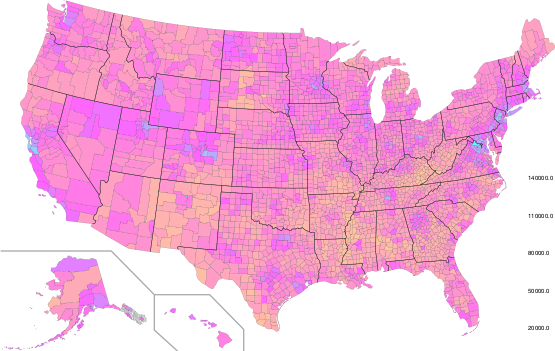

In [51]:
render( etree.tostring(svg_map_with_scale) )

Here I have a map of the United States colored by county respective to the color scale, in which the scale and coloring denotes the Median Household Income of a county. I decided to use render() rather than SVG() due to the fact that embedding the map as an SVG required a significant amount of more space and cased a significant decrease in running time as well as production time, almost causing my computer to freeze.

The color scale would not display for the PNG image so I shall explicitly state it. 
In ascending order, the scale goes from orange to pink to cyan. This means that counties with the lowest MHI's are colored deep pink and the highest MHI's a bright cyan

## A Map of Median Income By State

Here I fill the counties in the map respective to their states Median Household Income

In [52]:
for item in svg_map[0]:
    item.attrib['id'] = item.attrib['id'].replace('FIPS','_')
    item.attrib['fill'] = colors[State_FIPS[item.attrib['id'][:2] + '000']]
    
svg_map_with_scale = add_scale(svg_map, colors, labels, font_size=6, stroke=False, save_file=None)

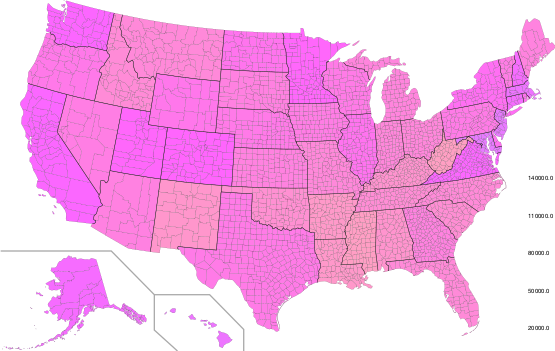

In [63]:
render ( etree.tostring(svg_map_with_scale) )

Here I have set each counties fill set to the states equivalent. Again the color scale was not appearing and so the color scale goes from orange to pink to cyan. Here we can see that no state is in the high end of the MHI range. This may represent a respectful distribution of wealth. The states with the darker shades of pink have higher MHIs (still around the national median), whereas the states with shades of lighter orange have lower MHIs.

## Conclusions

Through my report, what I found is that there are no entire states in the USA that land on the high end of the Median Household Income. What I do notice is that the highest MHI's are found in counties that I do not expect them to be in. I guess this goes to show that there are some hidden affluent communities in the country. 

I noticed that, in regards to the county MHIs respective to the state MHI, the allocation of color across the counties does not necessarily accurately represent their respective states MHI. For instance, California at the state level turns out to be around the US median in MHI, whereas across the counties, the MHI hovers below the median, with the exception of the coastal and southern counties. I believe this has to do with counties with higher populations having more weight compared to the counties with lower populations. So while there can be more affluent counties, the overall determinant in the state MHI resides more in the overall population, or in the counties with higher/lower populations.

## References

1. "What is the Definition of Median Household Income?", Lander, Steven. *PocketSense.com*. October 25, 2018. PocketSense.com/definition-median-household-income-26999.html. accesed Sept 28, 2019.